In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Download Reaching dataset

#### reaching_dataset.h5 [[download link](https://northwestern.app.box.com/s/xbe3xpnv6gpx0c1mrfhb1bal4cyei5n8)] [137MB]

## Load data

In [2]:
import deepdish as dd
data = dd.io.load('reaching_dataset.h5')

print 'dataset keys:', data.keys()
print 'events:', data['events'].keys()
print 'features:', data['features'].keys()
print 'number of PMd neurons:', len(data['neurons_PMd'])
print 'number of M1 neurons:', len(data['neurons_M1'])

dataset keys: ['neurons_M1', 'neurons_PMd', 'events', 'features']
events: ['rewardTime', 'goCueTime', 'targetOnTime']
features: ['endpointOfReach', 'reward']
number of PMd neurons: 195
number of M1 neurons: 219


# Part I: NeuroVis

In [3]:
from neurovis import NeuroVis

### Instantiate example PMd neuron

In [4]:
neuron_number = 91
spike_times = data['neurons_PMd'][neuron_number-1]
neuron_PMd = NeuroVis(spike_times, name = 'PMd %d' % neuron_number)

## Raster plot and PSTH aligned to target onset

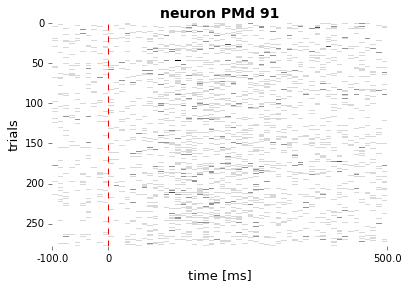

In [5]:
neuron_PMd.get_raster(events=data['events']['targetOnTime']);

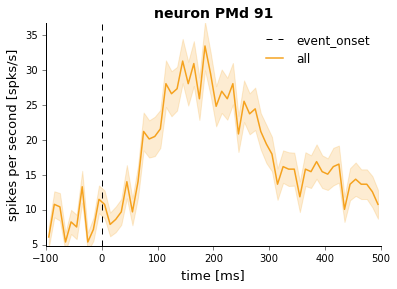

In [6]:
neuron_PMd.get_psth(events=data['events']['targetOnTime']);

## Let's visualize PSTHs separated by *conditions*

### Define conditions based on reach angle

In [7]:
conditions_by_reach = dict()

conditions_by_reach[0] = dict()
conditions_by_reach[0]['endpointOfReach'] = [0, 90] #can be a list with a single number or and interval

conditions_by_reach[1] = dict()
conditions_by_reach[1]['endpointOfReach'] = [90, 180]

conditions_by_reach[2] = dict()
conditions_by_reach[2]['endpointOfReach'] = [180, 270]

conditions_by_reach[3] = dict()
conditions_by_reach[3]['endpointOfReach'] = [270, 360]

### Plot PSTH

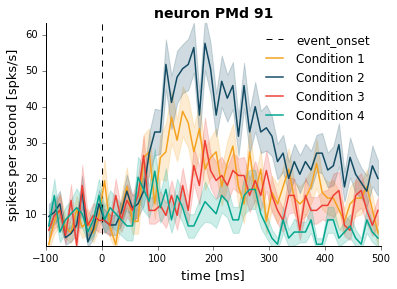

In [8]:
neuron_PMd.get_psth(events=data['events']['targetOnTime'],
                               features=data['features'],
                               conditions=conditions_by_reach);

### Make it look nicer

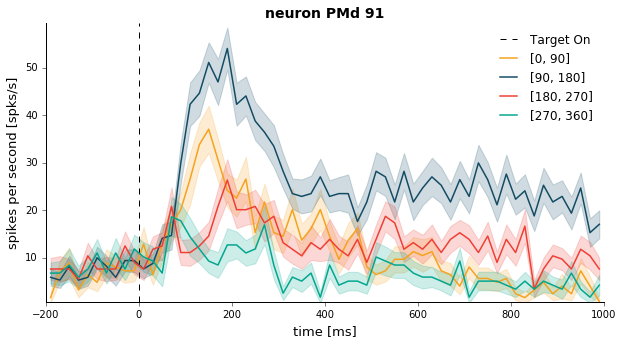

In [9]:
psth_PMd = neuron_PMd.get_psth(events=data['events']['targetOnTime'],
                               features=data['features'],
                               conditions=conditions_by_reach,
                               window=[-200,1000],
                               binsize=20, 
                               plot=False);

plt.figure(figsize=(10,5))
condition_names = [str(conditions_by_reach[i]['endpointOfReach']) for i in conditions_by_reach]
neuron_PMd.plot_psth(psth=psth_PMd,
                     event_name='Target On',
                     condition_names=condition_names);

### Raster plots for the same neuron and conditions

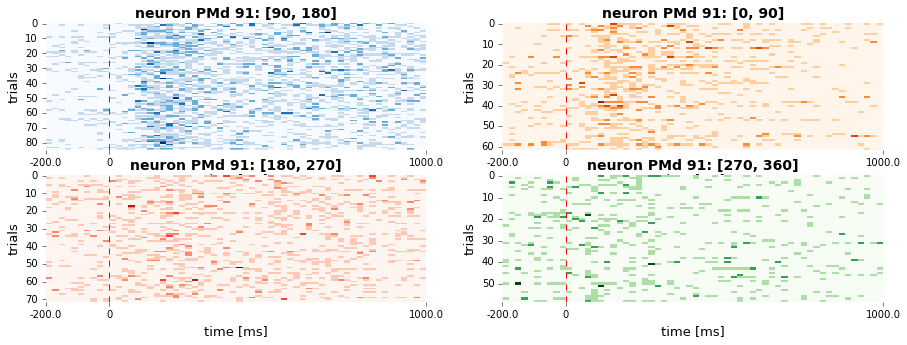

In [10]:
rasters_PMd = neuron_PMd.get_raster(events=data['events']['targetOnTime'],
                               features=data['features'],
                               conditions=conditions_by_reach,
                               window=[-200,1000],
                               binsize=20,
                               plot = False);

plt.figure(figsize=(15,5))
plot_order = np.array([2,1,3,4])
for cond in rasters_PMd['conditions']:
    plt.subplot(2,2,plot_order[cond])
    neuron_PMd.plot_raster(rasters_PMd, 
                           condition = cond+1,
                           cmap = ['Oranges','Blues','Reds','Greens'],
                           condition_names=condition_names)
    if i<2:
        plt.xlabel('')

### We can use .get_spikecounts to count the number of spikes within a certain time window relative to event onset 

In [11]:
spike_counts = neuron_PMd.get_spikecounts(events=data['events']['targetOnTime'], window=[0, 1200])
trial_type = neuron_PMd.get_trialtype(features=data['features'], conditions=conditions_by_reach)

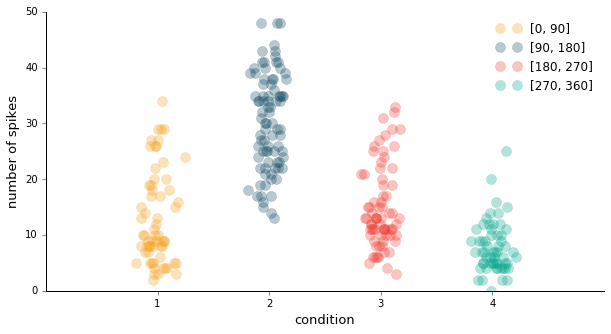

In [12]:
# Let's visualize the spike counts per trial for each condition
n_conditions = len(conditions_by_reach)
colors=['#F5A21E', '#134B64', '#EF3E34', '#02A68E']

plt.figure(figsize=(10,5))

for i in np.arange(n_conditions):
    idx = np.where(trial_type[:,i])[0]
    x_noise = 0.08*np.random.randn(np.size(idx))
    plt.plot(i+x_noise+1, spike_counts[idx],'.', color=colors[i], alpha=0.3, markersize=20)
    
plt.xlabel('condition')
plt.ylabel('number of spikes')
plt.xlim([0,5])
plt.xticks(np.arange(n_conditions)+1)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
plt.legend(condition_names, frameon=False)
plt.show()

## PSTH for an example M1 neuron aligned to GO cue

In [13]:
neuron_number = 100
spike_times = data['neurons_M1'][neuron_number-1]
neuron_M1 = NeuroVis(spike_times, name = 'M1 %d' % neuron_number)

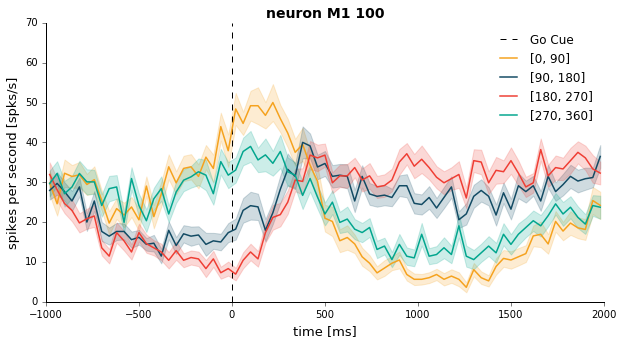

In [14]:
psth_M1 = neuron_M1.get_psth(events=data['events']['goCueTime'],
                             features=data['features'],
                             conditions=conditions_by_reach,
                             window=[-1000,2000],
                             binsize=40,
                             plot=False);

plt.figure(figsize=(10,5))
neuron_M1.plot_psth(psth=psth_M1,
                    event_name='Go Cue',
                    ylim=[0,70],
                    condition_names=condition_names);
plt.show()

## PSTH for an example M1 neuron aligned to reward

### Define conditions based on reward

In [15]:
conditions_by_reward = dict()

conditions_by_reward[0] = dict()
conditions_by_reward[0]['reward'] = [34] #dataset uses 34 for no reward and 32 for reward

conditions_by_reward[1] = dict()
conditions_by_reward[1]['reward'] = [32]

### Plot PSTH

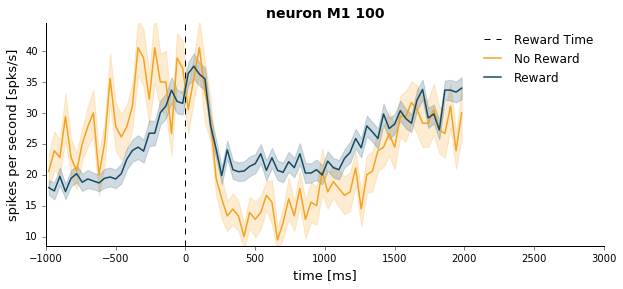

In [16]:
psth_M1 = neuron_M1.get_psth(events=data['events']['rewardTime'],
                            features=data['features'],
                            conditions=conditions_by_reward,
                            window=[-1000,2000],
                            binsize=40,
                            plot=False);

condition_names = ['No Reward','Reward']

plt.figure(figsize=(10,4))
neuron_M1.plot_psth(psth=psth_M1,
                    event_name='Reward Time',
                    condition_names=condition_names);
plt.xlim([-1000, 3000])
plt.show()

# Part II: NeuroPop

In [16]:
from neuropop import NeuroPop

## Organize data as preferred features and spike counts ($x$,  $\mathbf{Y}$)

### Extract reach direction $x$

In [17]:
# Get reach direction, ensure it is between [-pi, pi]
x = np.arctan2(np.sin(data['features']['endpointOfReach']*np.pi/180.0),
               np.cos(data['features']['endpointOfReach']*np.pi/180.0))

### Extract M1 spike counts $\mathbf{Y}$ 
- Select only neurons above a threshold firing rate 
- Align spike counts to the GO cue
- Use the convenience function ```get_spikecounts()``` from ```NeuroVis```

In [18]:
# Select only high firing rate neurons
M1_select = list()
threshold = 10.0

# Specify timestamps of events to which trials are aligned
align = data['events']['goCueTime']

# Specify a window of around the go cue for spike counts
window = [0., 500.] # milliseconds

# Get spike counts
Y = np.zeros([x.shape[0], len(data['neurons_M1'])])

for n in range(len(data['neurons_M1'])):
    this_neuron = NeuroVis(spiketimes = data['neurons_M1'][n])
    Y[:, n] = np.squeeze(this_neuron.get_spikecounts(events=align, window=window))

    # Short list a few high-firing neurons
    if this_neuron.firingrate > threshold:
        M1_select.append(n)

# Rescale spike counts to units of spikes/s
Y = Y/float(window[1]-window[0])*1e3

# How many neurons shortlisted?
print '%d M1 neurons had firing rates over %4.1f spks/s' % (len(M1_select), threshold)

107 M1 neurons had firing rates over 10.0 spks/s


### Split into train and test sets

In [19]:
from sklearn.cross_validation import train_test_split
Y_train, Y_test, x_train, x_test = train_test_split(Y, x, test_size=0.33, random_state=42)

### Create an instance of NeuroPop

In [20]:
pop = NeuroPop(n_neurons=len(M1_select), 
               tunemodel='gvm',
               n_repeats = 3,
               verbose=False)

## Let's fit tuning curves to the population

In [21]:
pop.fit(np.squeeze(x_train), Y_train[:, M1_select])

### Predict firing rates

In [22]:
Yhat_test = pop.predict(np.squeeze(x_test))

### Score the prediction

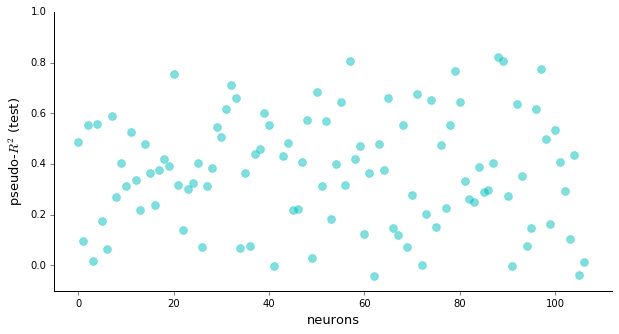

In [23]:
# calculate and plot the pseudo R2
Ynull = np.mean(Y_train[:, M1_select], axis=0)
pseudo_R2 = pop.score(Y_test[:, M1_select], Yhat_test, Ynull, method='pseudo_R2')

plt.figure(figsize=(10,5))
plt.plot(pseudo_R2, 'co', markeredgecolor='c', alpha=0.5, markersize=8)
plt.xlim([-5, len(M1_select)+5])
plt.ylim([-0.1, 1])
plt.xlabel('neurons')
plt.ylabel('pseudo-$R^2$ (test)')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')

### Visualize tuning curves

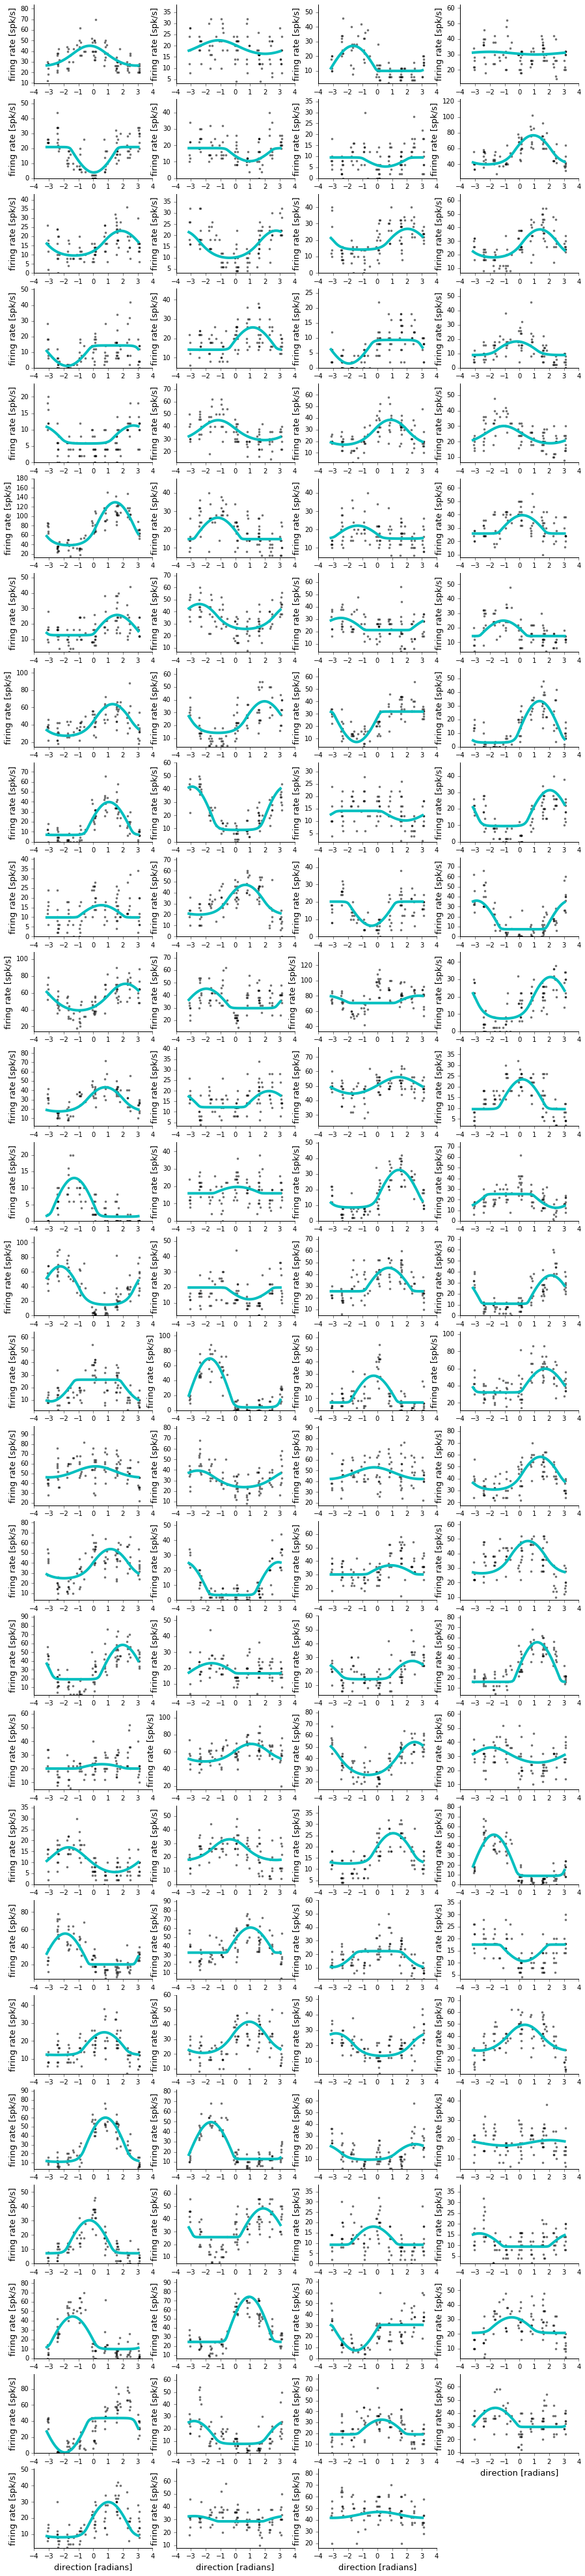

In [24]:
plt.figure(figsize=[15,70])

for neuron in range(len(M1_select)):
    plt.subplot(27,4,neuron+1)
    pop.display(x_test, Y_test[:, M1_select[neuron]], neuron=neuron, 
                ylim=[0.8*np.min(Y_test[:, M1_select[neuron]]), 1.2*np.max(Y_test[:, M1_select[neuron]])])
    #plt.axis('off')

plt.show()

## Decode reach direction from population vector

In [25]:
xhat_test = pop.decode(Y_test[:, M1_select])

### Visualize decoded reach direction

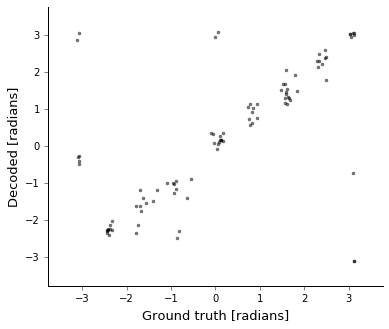

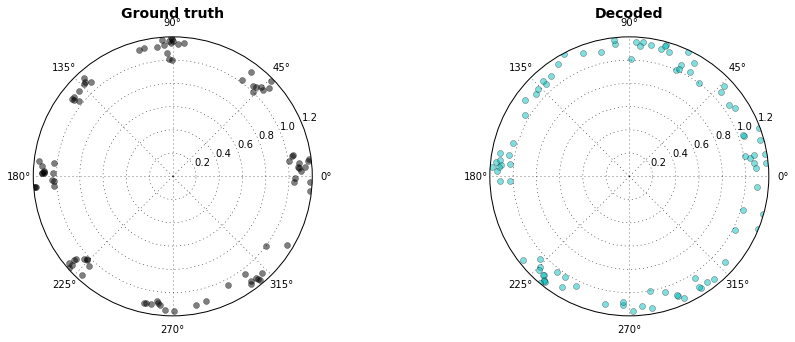

In [26]:
plt.figure(figsize=[6,5])

plt.plot(x_test, xhat_test, 'k.', alpha=0.5)
plt.xlim([-1.2*np.pi, 1.2*np.pi])
plt.ylim([-1.2*np.pi, 1.2*np.pi])
plt.xlabel('Ground truth [radians]')
plt.ylabel('Decoded [radians]')
plt.tick_params(axis='y', right='off')
plt.tick_params(axis='x', top='off')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.figure(figsize=[15,5])
jitter = 0.2*np.random.rand(x_test.shape[0])
plt.subplot(121, polar=True)
plt.plot(x_test, np.ones(x_test.shape[0]) + jitter, 'ko', alpha=0.5)
plt.title('Ground truth')

plt.subplot(122, polar=True)
plt.plot(xhat_test, np.ones(xhat_test.shape[0]) + jitter, 'co', alpha=0.5)
plt.title('Decoded')
plt.show()

### Score decoding performance

In [27]:
circ_corr = pop.score(x_test, xhat_test, method='circ_corr')
print 'Circular Correlation: %f' % (circ_corr)
cosine_dist = pop.score(x_test, xhat_test, method='cosine_dist')
print 'Cosine Distance: %f' % (cosine_dist)

Circular Correlation: 0.383749
Cosine Distance: 0.806964
